In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

from delfi.utils.viz import plot_pdf
from delfi.generator import Default

from lfimodels.channelomics.ChannelSingle import ChannelSingle
from lfimodels.channelomics.ChannelStats import ChannelStats

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 14,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

### Load trained posterior

In [45]:
folder = '../data/'
fn = 'learned_posteriors_pospischil_ntrain192962_kd.p'
time_stamp = fn[:fn.find('_')]

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 3
np.random.seed(seed)

In [46]:
mi_post_dict = d['model_idx_posterior']
p_post_dict = d['parameter_posterior']

## Check model index posterior 

### prior check
generate test data different priors on the models: $p(model) = 0.1, ..., 0.9$. Then predict the test set and check whether the average posterior prob of the model corresponds to the prior prob.

In [47]:
sx_train, sx_test, mtrain, mtest, data_norm, sx_obs, model_idx_mdn, prior_lims_kd, prior_lims_ks = mi_post_dict.values()

In [48]:
sx_test.shape

(2000, 25)

There are 1000 test samples for each model. Take 100 from $m1$ and 900 from $m2$, then $(200, 800)$, and so on. 

In [49]:
prior_probs = np.arange(0.1, 1., 0.1)
post_probs_mean = np.zeros_like(prior_probs)
sx_test_m1 = sx_test[:1000, ]
sx_test_m2 = sx_test[1000:, ]

for ii, pp in enumerate(prior_probs): 
    idx = int(pp * 1000)
    # up to idx for m1
    d1 = sx_test_m1[:idx, ]
    # from idx to end for m2
    d2 = sx_test_m2[idx:, ]
    test_data = np.vstack((d1, d2))
    test_m = np.hstack((np.zeros(idx), np.ones(1000 - idx))).astype(int).tolist()
    
    # predict 
    test_data_zt, _ = normalize(test_data, data_norm)
    p = model_idx_mdn.predict(test_data_zt)[:, 0]
    post_probs_mean[ii] = p.mean()

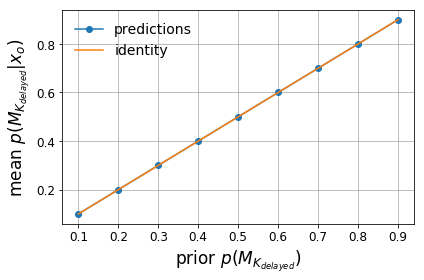

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(prior_probs, post_probs_mean, '-o', label='predictions')
ax.plot(prior_probs, prior_probs, label='identity')
ax.set_ylabel(r'mean $p(M_{K_{delayed}} | x_o)$')
ax.set_xlabel(r'prior $p(M_{K_{delayed}})$')
ax.grid()
ax.legend()
plt.tight_layout();

In [51]:
fn = time_stamp + '_channelexample_priorchecks_ntrain{}.png'.format(int(sx_train.shape[0]))
fig.savefig(os.path.join('../figures', fn), dpi=300)

## Check model parameter posterior 

Because we do not have the ground truth posteiror we can only check the quantiles and credible intervals of the marginals have a look at the covariances of the joint posterior. 

In [52]:
p_post_dict.keys()

dict_keys(['xo', 'sxo', 'parameter_mdn', 'gt', 'labels', 'sx_train', 'sx_test', 'data_norm', 'prior_norm', 'params_pred', 'params_pred_test', 'predicted_channel_type', 'loss_trace'])

In [53]:
xo, sxo, parameter_mdn, GT, labels, sx_train, sx_test, data_norm, prior_norm, params_pred, params_pred_test, predicted_channel_type, loss_trace = p_post_dict.values()

In [54]:
params_test = params_pred_test
sx_test_zt, _ = normalize(sx_test, data_norm)
params_test_zt, _ = normalize(params_test, prior_norm)

ntest = sx_test.shape[0]
ntrain = sx_train.shape[0]
n_params = params_pred_test.shape[1]
n_components = parameter_mdn.n_components

if predicted_channel_type == 'ks': 
    predicted_channel_type = 'kslow'
gt = GT[predicted_channel_type]
channel_type = predicted_channel_type

In [56]:
# quantiles, credible intervals for every dimension (5)
qis = np.zeros((n_params + 1, ntest))

credible_intervals = np.arange(0.05, 1., 0.05)
marginal_ci_counts = np.zeros((n_params + 1, ntest, credible_intervals.size))

covariances = []

ms_hat = []
ps_hat = []

# for every test sample 
fails = []

with tqdm.tqdm(total=ntest) as pbar: 
    for ii, (thetao_i, sxo_i) in enumerate(zip(params_test, sx_test_zt)): 

        # predict the posterior
        post_hat_zt = parameter_mdn.predict(sxo_i.reshape(1, -1))
        dd = post_hat_zt.get_dd_object()
        # transform back to original parameter range
        post_hat = post_hat_zt.ztrans_inv(prior_norm[0], prior_norm[1])
        marginals_hat = post_hat.get_marginals()
        
        ps_hat.append(post_hat)
        ms_hat.append(marginals_hat)
       
        pbar.update()
        # perform check for marginals         
        for vi, (mhat, th) in enumerate(zip(marginals_hat, thetao_i)):             
            # quantiles 
            qis[vi, ii] = mhat.get_quantile(th)[0]

            # credible intervals
            marginal_ci_counts[vi, ii, :] = mhat.get_credible_interval_counts(th, credible_intervals)

        # perform checks for joint 
        vi = n_params

        # quantiles 
        qis[vi, ii] = post_hat.get_quantile(thetao_i.reshape(1, -1))

        # covariances
#         covariances.append(post_hat.get_covariance_matrix())

100%|██████████| 1000/1000 [00:30<00:00, 32.84it/s]


## Overview plots

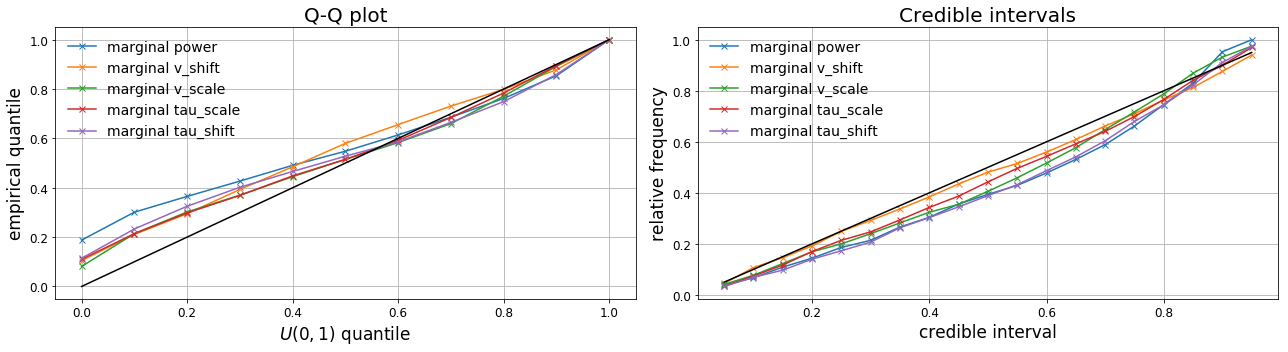

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

for mi in range(5):
    n, bins = np.histogram(qis[mi, ], bins='auto')
    sample_quantiles = np.cumsum(n / np.sum(n))
    theo_quantiles = np.linspace(0, 1, len(n))
    ax[0].set_title('Q-Q plot')
    ax[0].plot(theo_quantiles, sample_quantiles, 'x-', label=r'marginal ' + labels['kslow'][mi])    
    ax[0].legend()
    ax[0].grid()
    
    ax[1].set_title('Credible intervals')
    ax[1].plot(credible_intervals, marginal_ci_counts[mi,].mean(axis=0), 'x-', label=r'marginal ' + labels['kslow'][mi])
    ax[1].legend()
    ax[1].grid()

ax[0].plot(theo_quantiles, theo_quantiles, 'k')
ax[1].plot(credible_intervals, credible_intervals, 'k')

ax[0].set_ylabel('empirical quantile')
ax[0].set_xlabel(r'$\mathit{U}(0, 1)$ quantile')
ax[1].set_ylabel('relative frequency')
ax[1].set_xlabel('credible interval')
plt.tight_layout();

In [58]:
fn = time_stamp + '_channelexample_posteriorchecks_{}_ntrain{}_nc{}.png'.format(channel_type, int(ntrain), n_components)
fig.savefig(os.path.join('../figures', fn), dpi=300)

### Inspect individual marginals

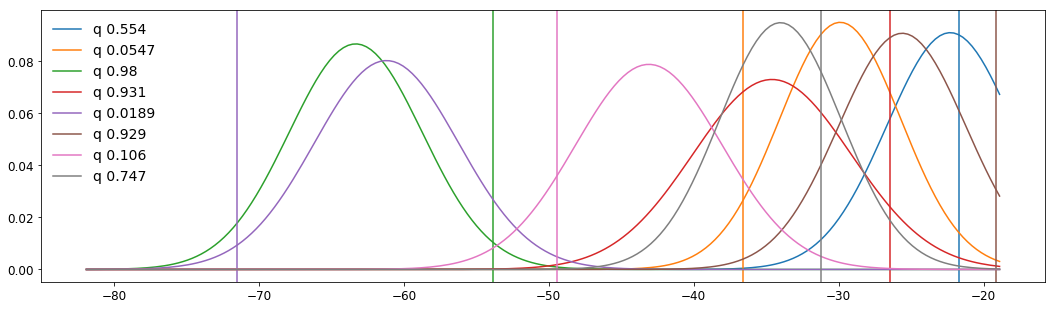

In [59]:
mi = 1
prior_lims = prior_lims_kd if predicted_channel_type == 'kd' else prior_lims_ks
pp = np.linspace(prior_lims[mi][0], prior_lims[mi][1], 200)

for i, m in enumerate(ms_hat): 
    mhat = m[mi]
    q = mhat.get_quantile(params_test[i][mi])[0]
    pd = mhat.eval_numpy(pp)
    plt.plot(pp, pd, label='q {:.3}'.format(qis[mi, i], q))
    plt.axvline(x=params_test[i][mi], color='C{}'.format(i))
        
    if i == 7: break
plt.legend()

# Posterior figures

In [60]:
# get posterior for gt params 
# normalize the observed data with training norm 
sx_obs, data_norm = normalize(sxo.squeeze(), data_norm)
# predict MoG parameters given observed data 
mog_posterior_pytorch = parameter_mdn.predict(sx_obs.reshape(1, -1))
# define as delfi distribution
mog_posterior_delfi_zt = mog_posterior_pytorch.get_dd_object()
# transform back to prior ranges 
mog_posterior_delfi = mog_posterior_delfi_zt.ztrans_inv(mean=prior_norm[0], std=prior_norm[1])

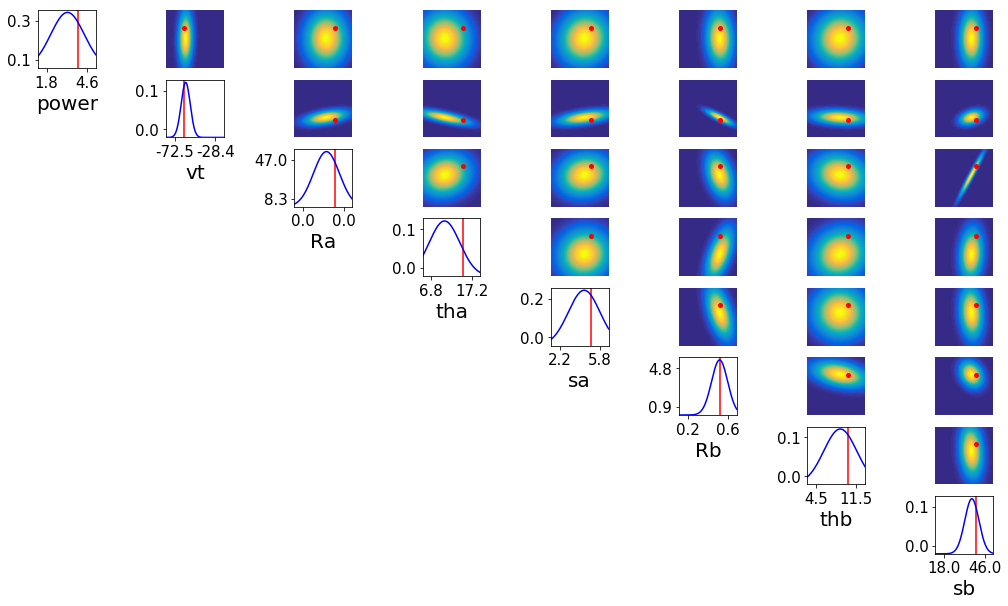

In [61]:
fig, ax = plot_pdf(mog_posterior_delfi, lims=prior_lims, figsize=(18, 10), ticks=True, 
                   labels_params=labels[predicted_channel_type], gt=gt)

In [62]:
fn = time_stamp + '_channelexample_posterior_{}_ntrain{}_nc{}.png'.format(channel_type, int(ntrain), n_components)
fig.savefig(os.path.join('../figures', fn), dpi=300)

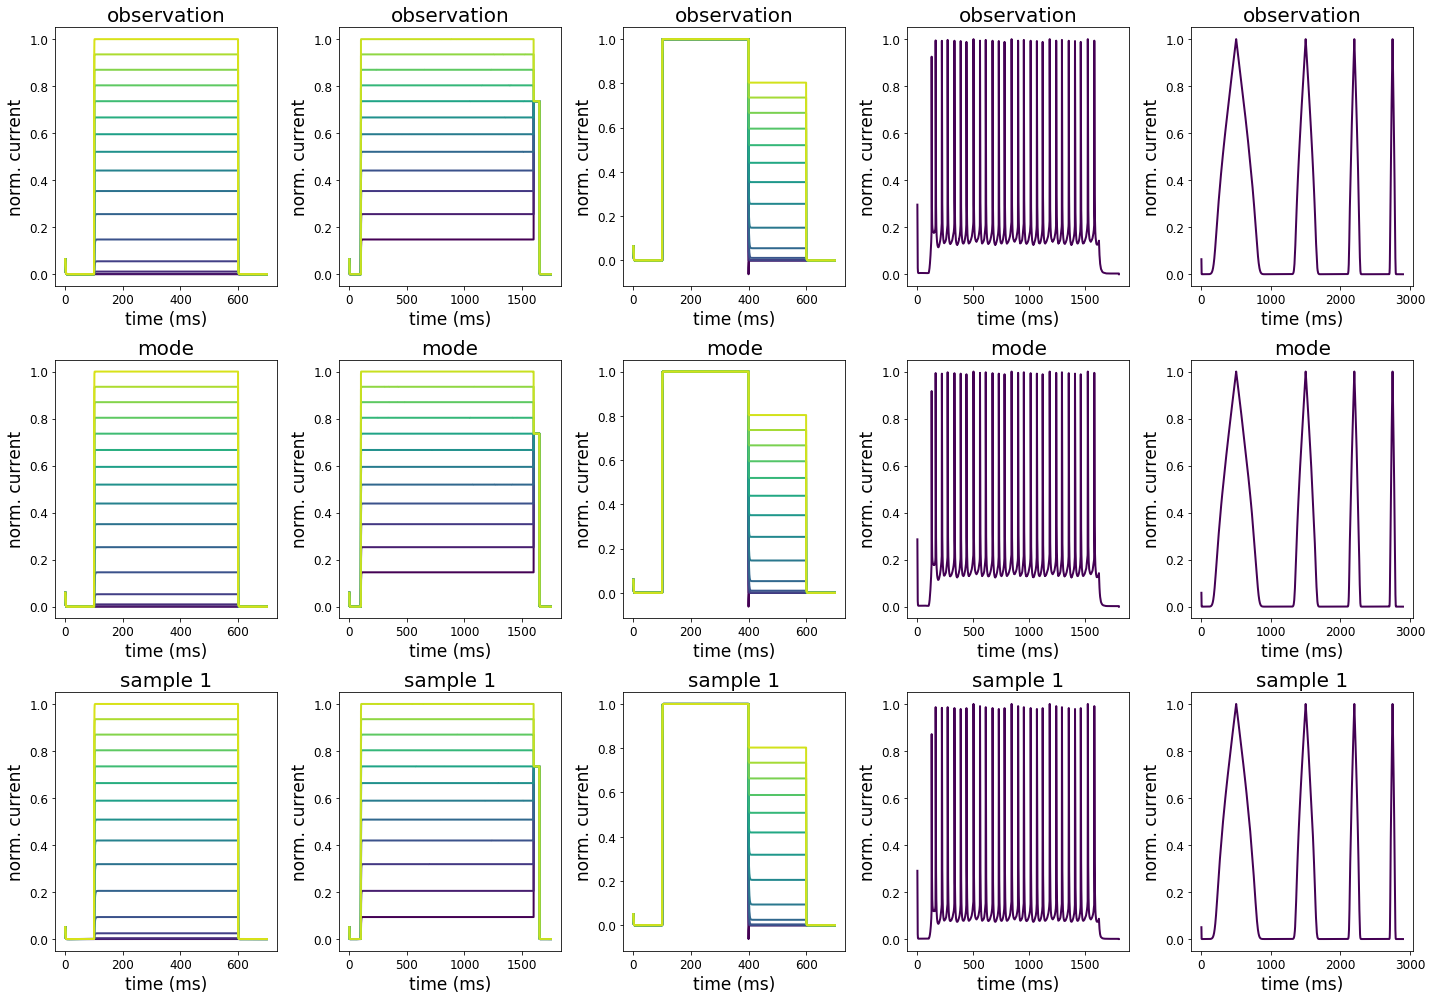

In [63]:
posterior = mog_posterior_delfi
n_params = len(gt)
lims = prior_lims
cython = True

mean, S = posterior.calc_mean_and_cov()
# m = posterior.xs[0].m
# S = posterior.xs[0].S

prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
num_protocols = len(prot)

num_samp = 1

# sampling at contour of 1 covariance away from mean (if samples from outside the prior box, contour is at prior box)
x_samp = np.random.randn(n_params, num_samp)
x_samp = np.divide(x_samp, np.linalg.norm(x_samp, axis=0))
x_samp = (np.dot(S, x_samp)).T + mean

# # sample from posterior
# x_samp = posterior.gen(n_samples=num_samp)

# correct for samples outside the prior box
x_samp = np.maximum(x_samp, lims[:,0])
x_samp = np.minimum(x_samp, lims[:,1])

params = np.concatenate((np.array([mean]), x_samp))

fig = plt.figure(figsize = (20, 10 + num_samp * 4))

# set up a simulator 
m = ChannelSingle(channel_type=channel_type, n_params=n_params, cython=cython)
s = ChannelStats(channel_type=predicted_channel_type)

for i in range(1+num_samp):
    x = m.gen_single(params[i, :])
    for p in range(num_protocols):
        I = x[prot[p]]['data']
        t = x[prot[p]]['time']
        num_levels = len(I[:,0])
        cm1 = mpl.cm.viridis
        col1 = [cm1(1.*k/num_levels) for k in range(num_levels)]
        
        for j in range(num_levels):
            if i==0:
                plt.subplot(2+num_samp,num_protocols,p+1)
                plt.plot(t, xo[0][0][prot[p]]['data'][j,], color = col1[j], lw=2)
                plt.xlabel('time (ms)')
                plt.ylabel('norm. current')
                plt.title('observation')
                
                plt.subplot(2+num_samp,num_protocols,num_protocols+p+1)
                plt.plot(t, I[j,], color = col1[j], lw=2)
                plt.xlabel('time (ms)')
                plt.ylabel('norm. current')
                plt.title('mode')
            else:
                plt.subplot(2+num_samp,num_protocols,(i+1)*num_protocols+p+1)
                plt.plot(t, I[j,], color = col1[j], lw=2)
                plt.xlabel('time (ms)')
                plt.ylabel('norm. current')
                plt.title('sample '+str(num_samp-i+1))
plt.tight_layout()

In [64]:
fn = time_stamp + '_channelexample_posteriorsamples_{}_ntrain{}_nc{}.png'.format(channel_type, int(ntrain), n_components)
fig.savefig(os.path.join('../figures', fn), dpi=300)

In [ ]:
# save posterior checks results 
result_dict = dict(qis=qis, qis_hat=qis_hat, dkl_ratios=dkl_ratios,
                  marginal_ci_counts=marginal_ci_counts, 
                  marginal_ci_counts_hat=marginal_ci_counts_hat, 
                  fails=fails, 
                  ntest=ntest, 
                  mus_exact=mus_exact, mus_hat=mus_hat, 
                  stds_exact=stds_exact, stds_hat=stds_hat, 
                  credible_intervals=credible_intervals, 
                  covariances=covariances, 
                  covariances_hat=covariances_hat, 
                  params_test=params_test, 
                  sx_test_zt=sx_test_zt, 
                  x_test=x_test, 
                  ps=ps, 
                  p_hats=ps_hat)

fn = time_stamp + 'posterior_checks_results_NB_ntrain{}_ns{}_ntest{}'.format(ntrain, sample_size, ntest) + '.p'
with open(os.path.join('../data', fn), 'wb') as outfile: 
    pickle.dump(result_dict, outfile, pickle.HIGHEST_PROTOCOL)